<a href="https://colab.research.google.com/github/wwangvodafone/airequest_pbl01/blob/main/pbl0102_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd                 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt   
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn import  metrics
from itertools import product
from sklearn.metrics import r2_score

In [ ]:
item_category = pd.read_csv('item_categories.csv')
item_category

,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100
...,...,...
9421,3500072,350
9422,3500073,350
9423,3500074,350
9424,3500075,350


In [ ]:
category_name = pd.read_csv('category_names.csv')
category_name.head()

,商品カテゴリID,商品カテゴリ名,カテゴリ
0,100,映画 - DVD,11
1,110,PCゲーム - 通常版,24
2,120,音楽 - その他,32
3,130,ゲーム - ゲーム機C,21
4,140,映画 - ブルーレイ,12


In [ ]:
item_category = pd.merge(item_category, category_name, on=['商品カテゴリID'], how='left')
item_category

,商品ID,商品カテゴリID,商品カテゴリ名,カテゴリ
0,1000001,100,映画 - DVD,11
1,1000002,100,映画 - DVD,11
2,1000003,100,映画 - DVD,11
3,1000004,100,映画 - DVD,11
4,1000005,100,映画 - DVD,11
...,...,...,...,...
9421,3500072,350,本 - オーディオブック_タイプB,61
9422,3500073,350,本 - オーディオブック_タイプB,61
9423,3500074,350,本 - オーディオブック_タイプB,61
9424,3500075,350,本 - オーディオブック_タイプB,61


In [ ]:
sale_his = pd.read_csv('sales_history.csv')
sale_his['年'] = sale_his['日付'].apply(lambda x: x.split('-')[0])
sale_his['月'] = sale_his['日付'].apply(lambda x: x.split('-')[1])

sale_his

,日付,店舗ID,商品ID,商品価格,売上個数,年,月
0,2018-01-01,9,1000001,420,1.0,2018,01
1,2018-01-01,6,1000001,420,1.0,2018,01
2,2018-01-01,10,1000001,420,1.0,2018,01
3,2018-01-01,0,1000017,250,1.0,2018,01
4,2018-01-01,1,1000017,250,1.0,2018,01
...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,2019,10
1119566,2019-10-31,7,3400009,1020,1.0,2019,10
1119567,2019-10-31,7,3400012,510,1.0,2019,10
1119568,2019-10-31,4,3500001,340,1.0,2019,10


In [ ]:
gp_time = sale_his.groupby(['年', '月']).count().reset_index()[['年', '月']]
gp_time['月ブロック'] = list(range(len(gp_time)))

# testデータ用に、評価対象期間である2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': '2019',
    '月': '12'
}, ignore_index=True)

gp_time

,年,月,月ブロック
0,2018,01,0
1,2018,02,1
2,2018,03,2
3,2018,04,3
4,2018,05,4
5,2018,06,5
6,2018,07,6
7,2018,08,7
8,2018,09,8
9,2018,10,9


In [ ]:
sale_his = pd.merge(sale_his, gp_time, on=['年', '月'], how='left')
sale_his

,日付,店舗ID,商品ID,商品価格,売上個数,年,月,月ブロック
0,2018-01-01,9,1000001,420,1.0,2018,01,0
1,2018-01-01,6,1000001,420,1.0,2018,01,0
2,2018-01-01,10,1000001,420,1.0,2018,01,0
3,2018-01-01,0,1000017,250,1.0,2018,01,0
4,2018-01-01,1,1000017,250,1.0,2018,01,0
...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,2019,10,21
1119566,2019-10-31,7,3400009,1020,1.0,2019,10,21
1119567,2019-10-31,7,3400012,510,1.0,2019,10,21
1119568,2019-10-31,4,3500001,340,1.0,2019,10,21


In [ ]:
sales_month = sale_his.groupby('月ブロック').agg({'売上個数': np.sum}).reset_index()
sales_month

,月ブロック,売上個数
0,0,69027.0
1,1,67740.0
2,2,77767.0
3,3,55991.0
4,4,53425.0
5,5,64901.0
6,6,60687.0
7,7,64360.0
8,8,58448.0
9,9,60160.0


In [ ]:
gp_month = sale_his.groupby(['月ブロック',  '商品ID', '店舗ID']).agg({'売上個数': np.sum, '商品価格': np.median}).reset_index()
gp_month

,月ブロック,商品ID,店舗ID,売上個数,商品価格
0,0,1000001,0,6.0,420
1,0,1000001,1,2.0,325
2,0,1000001,2,1.0,420
3,0,1000001,3,2.0,420
4,0,1000001,5,2.0,380
...,...,...,...,...,...
495129,21,3500070,16,1.0,420
495130,21,3500071,13,1.0,590
495131,21,3500072,2,1.0,420
495132,21,3500072,16,1.0,420


In [ ]:
all_combination = []

# '月'、'商品ID'、 '店舗ID'の全組み合わせを作成する
columns = ['月ブロック', '商品ID', '店舗ID']

for i in range(22):
  train_block = sale_his[sale_his['月ブロック']==i]
  all_combination.append(np.array(list(product([i], train_block['商品ID'].unique(), train_block['店舗ID'].unique()))))

all_combination = pd.DataFrame(np.vstack(all_combination), columns=columns)

all_combination.sort_values(columns, inplace=True)

#print(all_combination.info())
print(all_combination)  

         月ブロック     商品ID  店舗ID
3            0  1000001     0
4            0  1000001     1
7            0  1000001     2
15           0  1000001     3
16           0  1000001     4
...        ...      ...   ...
1644680     21  3500073    13
1644694     21  3500073    14
1644679     21  3500073    15
1644685     21  3500073    16
1644693     21  3500073    17

[1648926 rows x 3 columns]


In [ ]:
# all_combinationに売上履歴データを追加する
all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')

# 売上個数がNaNとなっている箇所は、売上個数0個として値を埋める
all_train['売上個数'] = all_train['売上個数'].fillna(0)

all_train

,月ブロック,商品ID,店舗ID,売上個数,商品価格
0,0,1000001,0,6.0,420.0
1,0,1000001,1,2.0,325.0
2,0,1000001,2,1.0,420.0
3,0,1000001,3,2.0,420.0
4,0,1000001,4,0.0,NaN
...,...,...,...,...,...
1648921,21,3500073,13,0.0,NaN
1648922,21,3500073,14,0.0,NaN
1648923,21,3500073,15,0.0,NaN
1648924,21,3500073,16,0.0,NaN


In [ ]:
all_train = all_train.fillna(0)
#all_train.dropna(how='any', inplace=True)
all_train

,月ブロック,商品ID,店舗ID,売上個数,商品価格
0,0,1000001,0,6.0,420.0
1,0,1000001,1,2.0,325.0
2,0,1000001,2,1.0,420.0
3,0,1000001,3,2.0,420.0
4,0,1000001,4,0.0,0.0
...,...,...,...,...,...
1648921,21,3500073,13,0.0,0.0
1648922,21,3500073,14,0.0,0.0
1648923,21,3500073,15,0.0,0.0
1648924,21,3500073,16,0.0,0.0


In [ ]:
product_price = sale_his.copy()

product_price.pop('売上個数')
product_price = product_price.groupby(['月ブロック', '商品ID', '店舗ID']).agg({'商品価格':'median'}).reset_index()
#product_price.pop('月ブロック')
product_price_12 = product_price[product_price['月ブロック']==12]
product_price_this_year = product_price[product_price['月ブロック']>12]
product_price_last_year = product_price[product_price['月ブロック']<12]
product_price_12

,月ブロック,商品ID,店舗ID,商品価格
300979,12,1000001,0,420
300980,12,1000001,3,420
300981,12,1000001,4,420
300982,12,1000001,5,420
300983,12,1000001,8,420
...,...,...,...,...
323944,12,3500059,3,420
323945,12,3500059,6,420
323946,12,3500059,7,420
323947,12,3500059,8,420


In [ ]:
test_df = pd.read_csv('test.csv')
new_test = pd.merge(test_df, product_price_12, on=['商品ID', '店舗ID'], how='left')
new_test['商品価格'].fillna(0, inplace=True)
have_price = new_test[new_test['商品価格']!=0.0]

have_price

,index,商品ID,店舗ID,月ブロック,商品価格
0,0,1000001,0,12.0,420.0
3,3,1000001,3,12.0,420.0
4,4,1000001,4,12.0,420.0
5,5,1000001,5,12.0,420.0
8,8,1000001,8,12.0,420.0
...,...,...,...,...,...
3040,3040,3400003,16,12.0,1190.0
3041,3041,3400003,17,12.0,1190.0
3044,3044,3500001,2,12.0,420.0
3049,3049,3500001,7,12.0,420.0


In [ ]:
test_df = pd.read_csv('test.csv')
new_test = pd.merge(test_df, product_price_this_year, on=['商品ID', '店舗ID'], how='left')
new_test = new_test.groupby(['商品ID', '店舗ID']).agg({'商品価格':'median'}).reset_index()
# 評価対象期間が2019年12月(月ブロック: 23)であるという情報を追加
new_test['月ブロック'] = 23
new_test = have_price.set_index(['商品ID', '店舗ID']).combine_first(new_test.set_index(['商品ID', '店舗ID'])).reset_index()
new_test=new_test[['商品ID', '店舗ID', '月ブロック', '商品価格']]
new_test['月ブロック'] = 23
new_test

,商品ID,店舗ID,月ブロック,商品価格
0,1000001,0,23,420.0
1,1000001,1,23,NaN
2,1000001,2,23,250.0
3,1000001,3,23,420.0
4,1000001,4,23,420.0
...,...,...,...,...
3055,3500001,13,23,420.0
3056,3500001,14,23,NaN
3057,3500001,15,23,200.0
3058,3500001,16,23,420.0


In [ ]:
new_test.fillna(0, inplace=True)
no_price = new_test[new_test['商品価格']==0.0]

no_price

,商品ID,店舗ID,月ブロック,商品価格
1,1000001,1,23,0.0
37,1000003,1,23,0.0
45,1000003,9,23,0.0
51,1000003,15,23,0.0
55,1000004,1,23,0.0
...,...,...,...,...
3043,3500001,1,23,0.0
3047,3500001,5,23,0.0
3053,3500001,11,23,0.0
3056,3500001,14,23,0.0


In [ ]:
no_price = no_price.drop(['商品価格', '月ブロック'], axis=1)
no_price = pd.merge(no_price, product_price_last_year, on=['商品ID', '店舗ID'], how='left')
no_price = no_price.groupby(['商品ID', '店舗ID']).agg({'商品価格':'median'}).reset_index()
no_price

,商品ID,店舗ID,商品価格
0,1000001,1,420.0
1,1000003,1,250.0
2,1000003,9,250.0
3,1000003,15,217.5
4,1000004,1,250.0
...,...,...,...
352,3500001,1,NaN
353,3500001,5,420.0
354,3500001,11,NaN
355,3500001,14,420.0


In [ ]:
new_test = no_price.set_index(['商品ID', '店舗ID']).combine_first(new_test.set_index(['商品ID', '店舗ID'])).reset_index()
new_test

,商品ID,店舗ID,商品価格,月ブロック
0,1000001,0,420.0,23.0
1,1000001,1,420.0,23.0
2,1000001,2,250.0,23.0
3,1000001,3,420.0,23.0
4,1000001,4,420.0,23.0
...,...,...,...,...
3055,3500001,13,420.0,23.0
3056,3500001,14,420.0,23.0
3057,3500001,15,200.0,23.0
3058,3500001,16,420.0,23.0


In [ ]:
new_test.fillna(0, inplace=True)
no_price = new_test[new_test['商品価格']==0.0]

no_price

,商品ID,店舗ID,商品価格,月ブロック
533,1200013,11,0.0,23.0
804,1200028,12,0.0,23.0
843,1200030,15,0.0,23.0
959,1200037,5,0.0,23.0
1153,1400004,1,0.0,23.0
...,...,...,...,...
2930,3100001,14,0.0,23.0
2983,3300001,13,0.0,23.0
2985,3300001,15,0.0,23.0
3043,3500001,1,0.0,23.0


In [ ]:
no_price.to_csv('/tmp/no_price.csv')

In [ ]:
price_productid = product_price.groupby(['商品ID']).agg({'商品価格':'median'}).reset_index()
price_productid

,商品ID,商品価格
0,1000001,420.0
1,1000002,250.0
2,1000003,250.0
3,1000004,250.0
4,1000005,250.0
...,...,...
9035,3500069,420.0
9036,3500070,420.0
9037,3500071,590.0
9038,3500072,420.0


In [ ]:
no_price_shopid = no_price.copy()
no_price_shopid = no_price_shopid.drop(['商品価格'], axis=1)
no_price_shopid = pd.merge(no_price_shopid, price_productid, on=['商品ID'], how='left')
#no_price_shopid = no_price_shopid.groupby(['商品ID', '店舗ID']).agg({'商品価格':'mean'}).reset_index()

no_price_shopid

,商品ID,店舗ID,月ブロック,商品価格
0,1200013,11,23.0,510.0
1,1200028,12,23.0,420.0
2,1200030,15,23.0,510.0
3,1200037,5,23.0,3650.0
4,1400004,1,23.0,340.0
...,...,...,...,...
130,3100001,14,23.0,1020.0
131,3300001,13,23.0,1780.0
132,3300001,15,23.0,1780.0
133,3500001,1,23.0,420.0


In [ ]:
new_test = no_price_shopid.set_index(['商品ID', '店舗ID']).combine_first(new_test.set_index(['商品ID', '店舗ID'])).reset_index()
new_test['月ブロック'] = 23
new_test

,商品ID,店舗ID,商品価格,月ブロック
0,1000001,0,420.0,23
1,1000001,1,420.0,23
2,1000001,2,250.0,23
3,1000001,3,420.0,23
4,1000001,4,420.0,23
...,...,...,...,...
3055,3500001,13,420.0,23
3056,3500001,14,420.0,23
3057,3500001,15,200.0,23
3058,3500001,16,420.0,23


In [ ]:
no_price = new_test[new_test['商品価格']==0.0]

no_price

,商品ID,店舗ID,商品価格,月ブロック


In [ ]:
dataset = pd.concat([all_train, new_test])
dataset

,月ブロック,商品ID,店舗ID,売上個数,商品価格
0,0,1000001,0,6.0,420.0
1,0,1000001,1,2.0,325.0
2,0,1000001,2,1.0,420.0
3,0,1000001,3,2.0,420.0
4,0,1000001,4,0.0,0.0
...,...,...,...,...,...
3055,23,3500001,13,NaN,420.0
3056,23,3500001,14,NaN,420.0
3057,23,3500001,15,NaN,200.0
3058,23,3500001,16,NaN,420.0


In [ ]:
lag = dataset.copy()
    
lag['月ブロック'] = lag['月ブロック'] + 12
lag = lag.rename(columns={'売上個数': '12ヶ月前の売上個数'})
lag

,月ブロック,商品ID,店舗ID,12ヶ月前の売上個数,商品価格
0,12,1000001,0,6.0,420.0
1,12,1000001,1,2.0,325.0
2,12,1000001,2,1.0,420.0
3,12,1000001,3,2.0,420.0
4,12,1000001,4,0.0,0.0
...,...,...,...,...,...
3055,35,3500001,13,NaN,420.0
3056,35,3500001,14,NaN,420.0
3057,35,3500001,15,NaN,200.0
3058,35,3500001,16,NaN,420.0


In [ ]:
dataset2 = pd.merge(dataset, lag, on=['月ブロック', '商品ID', '店舗ID', '商品価格'], how='left')
#print(dataset2.groupby('月ブロック').agg({'12ヶ月前の売上個数': 'count'}))
dataset2

,月ブロック,商品ID,店舗ID,売上個数,商品価格,12ヶ月前の売上個数
0,0,1000001,0,6.0,420.0,NaN
1,0,1000001,1,2.0,325.0,NaN
2,0,1000001,2,1.0,420.0,NaN
3,0,1000001,3,2.0,420.0,NaN
4,0,1000001,4,0.0,0.0,NaN
...,...,...,...,...,...,...
1651981,23,3500001,13,NaN,420.0,3.0
1651982,23,3500001,14,NaN,420.0,NaN
1651983,23,3500001,15,NaN,200.0,NaN
1651984,23,3500001,16,NaN,420.0,NaN


In [ ]:
dataset3 = pd.merge(dataset2, item_category, on='商品ID', how='left')
#dataset3.商品カテゴリ名 = LabelEncoder().fit_transform(dataset3.商品カテゴリ名.astype(str))
dataset3 = dataset3.drop('商品カテゴリ名', axis=1)
dataset3

,月ブロック,商品ID,店舗ID,売上個数,商品価格,12ヶ月前の売上個数,商品カテゴリID,カテゴリ
0,0,1000001,0,6.0,420.0,NaN,100,11
1,0,1000001,1,2.0,325.0,NaN,100,11
2,0,1000001,2,1.0,420.0,NaN,100,11
3,0,1000001,3,2.0,420.0,NaN,100,11
4,0,1000001,4,0.0,0.0,NaN,100,11
...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,NaN,420.0,3.0,350,61
1651982,23,3500001,14,NaN,420.0,NaN,350,61
1651983,23,3500001,15,NaN,200.0,NaN,350,61
1651984,23,3500001,16,NaN,420.0,NaN,350,61


In [ ]:
dataset3 = pd.merge(dataset3, gp_time, on='月ブロック', how='left')
dataset3

,月ブロック,商品ID,店舗ID,売上個数,商品価格,12ヶ月前の売上個数,商品カテゴリID,カテゴリ,年,月
0,0,1000001,0,6.0,420.0,NaN,100,11,2018,01
1,0,1000001,1,2.0,325.0,NaN,100,11,2018,01
2,0,1000001,2,1.0,420.0,NaN,100,11,2018,01
3,0,1000001,3,2.0,420.0,NaN,100,11,2018,01
4,0,1000001,4,0.0,0.0,NaN,100,11,2018,01
...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,NaN,420.0,3.0,350,61,2019,12
1651982,23,3500001,14,NaN,420.0,NaN,350,61,2019,12
1651983,23,3500001,15,NaN,200.0,NaN,350,61,2019,12
1651984,23,3500001,16,NaN,420.0,NaN,350,61,2019,12


In [ ]:
dataset3['年'] = dataset3['年'].astype(int)
dataset3['月'] = dataset3['月'].astype(int)
dataset3 = dataset3.fillna(0)

dataset3

,月ブロック,商品ID,店舗ID,売上個数,商品価格,12ヶ月前の売上個数,商品カテゴリID,カテゴリ,年,月
0,0,1000001,0,6.0,420.0,0.0,100,11,2018,1
1,0,1000001,1,2.0,325.0,0.0,100,11,2018,1
2,0,1000001,2,1.0,420.0,0.0,100,11,2018,1
3,0,1000001,3,2.0,420.0,0.0,100,11,2018,1
4,0,1000001,4,0.0,0.0,0.0,100,11,2018,1
...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,0.0,420.0,3.0,350,61,2019,12
1651982,23,3500001,14,0.0,420.0,0.0,350,61,2019,12
1651983,23,3500001,15,0.0,200.0,0.0,350,61,2019,12
1651984,23,3500001,16,0.0,420.0,0.0,350,61,2019,12


In [ ]:
train_dataset = dataset3[(dataset3['月ブロック'] >= 12) & (dataset3['月ブロック'] != 23)]

test_dataset = dataset3[dataset3['月ブロック'] == 23]

In [ ]:
min = np.amin(train_dataset['商品価格'],0)
print(min)
max = np.amax(train_dataset['商品価格'],0)
max

0.0


62880.0

In [ ]:
def std_exclude(df):
    """
    標準偏差の２倍以上の値は取り除く
    """
    columns = df[['商品価格']].columns

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        boder = np.abs(df[col] - mean) / std
        df = df[(boder < 12)]

    return df

In [ ]:
train_dataset = std_exclude(train_dataset)


In [ ]:
min = np.amin(train_dataset['商品価格'],0)
print(min)
max = np.amax(train_dataset['商品価格'],0)
max

0.0


9520.0

In [ ]:
train_dataset

,月ブロック,商品ID,店舗ID,売上個数,商品価格,12ヶ月前の売上個数,商品カテゴリID,カテゴリ,年,月
989100,12,1000001,0,2.0,420.0,6.0,100,11,2019,1
989101,12,1000001,1,0.0,0.0,0.0,100,11,2019,1
989102,12,1000001,2,0.0,0.0,0.0,100,11,2019,1
989103,12,1000001,3,5.0,420.0,2.0,100,11,2019,1
989104,12,1000001,4,4.0,420.0,0.0,100,11,2019,1
...,...,...,...,...,...,...,...,...,...,...
1648921,21,3500073,13,0.0,0.0,0.0,350,61,2019,10
1648922,21,3500073,14,0.0,0.0,0.0,350,61,2019,10
1648923,21,3500073,15,0.0,0.0,0.0,350,61,2019,10
1648924,21,3500073,16,0.0,0.0,0.0,350,61,2019,10


In [ ]:
X_train = train_dataset.drop(['月ブロック','売上個数', '年'], axis=1)
y_train = train_dataset['売上個数']

X_test = test_dataset.drop(['月ブロック','売上個数', '年'], axis=1)

In [ ]:
X_test

,商品ID,店舗ID,商品価格,12ヶ月前の売上個数,商品カテゴリID,カテゴリ,月
1648926,1000001,0,420.0,0.0,100,11,12
1648927,1000001,1,420.0,0.0,100,11,12
1648928,1000001,2,250.0,0.0,100,11,12
1648929,1000001,3,420.0,9.0,100,11,12
1648930,1000001,4,420.0,7.0,100,11,12
...,...,...,...,...,...,...,...
1651981,3500001,13,420.0,3.0,350,61,12
1651982,3500001,14,420.0,0.0,350,61,12
1651983,3500001,15,200.0,0.0,350,61,12
1651984,3500001,16,420.0,0.0,350,61,12


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 49 kB/s 


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, min_child_weight=5, max_depth=4)
xgb.fit(X_train,y_train)

[02:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
score = RF.score(X_train, y_train)
score

0.9509685319644373

In [ ]:
#Random Search CV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
        'min_samples_split': randint(low=1, high=20),
        'min_samples_leaf': randint(low=1, high=20),
        'max_depth': randint(low=1, high=5),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rnd_search.best_params_

{'max_depth': 3,
 'max_features': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 152}

In [ ]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=152, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# RF Regressor
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(oob_score=True, random_state=1, max_features=3, n_estimators=158, min_samples_leaf=2, min_samples_split=12)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      n_estimators=158, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
# Grid Searcg CV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 150, 200], 'max_features': [3, 5, 8], 'min_samples_split': [ 8, 10, 15], 'min_samples_leaf': [3, 4, 5]},
    #{'min_samples_split': [5, 10, 15, 20], 'min_samples_leaf': [1, 2, 3, 4]},
    #{'max_depth':[2, 3, 5, 7, 9]},
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=1)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
grid_search.best_params_ 

{'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Random Froest Regressor
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(oob_score=True, random_state=1, max_features=2, n_estimators=100)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
# KFold RF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

RF = RandomForestRegressor(oob_score=True, random_state=1, max_features=3, n_estimators=200, min_samples_split=10, min_samples_leaf=3)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
skf = StratifiedKFold(n_splits=20)

predictors = X_train.copy()
predictors.reset_index(drop=True, inplace=True)
targets = y_train.copy()
targets.reset_index(drop=True, inplace=True)

i = 0
for train_index, test_index in kf.split(predictors, targets):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = predictors.iloc[train_index], predictors.iloc[test_index]
    ytrain, ytest = targets.iloc[train_index], targets.iloc[test_index]

    print(i) 
    i = i + 1
    # For training, fit() is used
    RF.fit(Xtrain, ytrain)

    # Default metric is R2 for regression, which can be accessed by score()
    score = RF.score(Xtest, ytest)
    print(score)
 
    # For other metrics, we need the predictions of the model
    y_pred = RF.predict(Xtest)
    #print(y_pred)

    mean_squared_error = metrics.mean_squared_error(ytest, y_pred)
    print(mean_squared_error)
    r2_score = metrics.r2_score(ytest, y_pred)
    print(r2_score)


In [ ]:
prediction_rf = RF.predict(X_test)
prediction_rf

array([1.67, 1.73, 2.48, ..., 1.19, 1.3 , 1.41])

In [ ]:
#KFold LGB
from sklearn.model_selection import KFold
import lightgbm as lgb
# 5つのモデルを保存するリストの初期化
models = []

# 学習用データでの予測値を保存するデータフレームの初期化
df_train_preds = pd.DataFrame({'y_train': y_train})

# 検証用データでの予測値を保存するデータフレームの初期化
df_eval_preds = pd.DataFrame({'y_eval': [],
                              'y_eval_pred': []})
# R^2を保存するデータフレームの初期化
df_R2 = pd.DataFrame({'train': [],
                      'eval': []})

# RMSEを保存するデータフレームの初期化
df_RMSE =pd.DataFrame({'train': [],
                       'eval': []})

# ラウンド数の初期化
round_no = 0


# 【ブロック２：　モデルの学習】
# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = KFold(n_splits=5, shuffle=True,  random_state=42)


# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'regression',      # 目的関数：回帰
              'metric': 'rmse',               # 分類モデルの性能を測る指標
              'learning_rate': 0.1 }          # 学習率（初期値0.1）
    
    # 学習
    evaluation_results = {}                              # 学習の経過を保存する箱
    model = lgb.train(params,                            # 上記で設定したパラメータ
                      lgb_train,                         # 使用するデータセット
                      num_boost_round=1000,              # 学習の回数
                      valid_names=['train', 'valid'],    # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],  # モデル検証のデータセット
                      evals_result=evaluation_results,   # 学習の経過を保存
                      early_stopping_rounds=20,          # アーリーストッピング
                      verbose_eval=0)                    # 学習の経過の非表示
    
    # 学習が終わったモデルをリストに保存
    models.append(model) 
    
    
    # 【ブロック３：　モデルで予測】
    # 学習したモデルで予測
    y_train_pred = model.predict(X_train_cv, num_iteration=model.best_iteration)
    y_eval_pred = model.predict(X_eval_cv, num_iteration=model.best_iteration)
    
    # 学習用データでの予測値をデータフレームに保存
    df_train_cv_pred = pd.DataFrame({round_no: y_train_pred},
                                     index=train_cv_no)
    df_train_preds = df_train_preds.join(df_train_cv_pred, how='left')
    
    # 検証用データでの予測値をデータフレームに保存
    df_eval_pred = pd.DataFrame({'y_eval': y_eval_cv,
                                 'y_eval_pred': y_eval_pred})
    df_eval_preds = df_eval_preds.append(df_eval_pred)    

    #  r2_score を計算
    train_score = r2_score(y_train_cv, y_train_pred)
    eval_score = r2_score(y_eval_cv, y_eval_pred)
    
    #  RMSE を計算
    train_RMSE_score = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
    eval_RMSE_score = np.sqrt(mean_squared_error(y_eval_cv, y_eval_pred))
    
    # スコアを表示
    print('R^2 train: %.5f, eval: %.5f' 
          % (train_score, eval_score),
         '  |  RMSE train: %.5f, eval: %.5f' 
          % (train_RMSE_score, eval_RMSE_score))
    
    # R2の保存
    df_R2_cv = pd.DataFrame({'train': [train_score],
                             'eval': [eval_score]},
                             index=[round_no])
    df_R2 = df_R2.append(df_R2_cv)
    
    # RMSEの保存
    df_RMSE_cv =pd.DataFrame({'train': [train_RMSE_score],
                              'eval': [eval_RMSE_score]},
                              index=[round_no])
    df_RMSE = df_RMSE.append(df_RMSE_cv)
    
    # ラウンド数のカウンタを更新
    round_no += 1


# 保存したR2の平均値    
R2_ave = df_R2.mean().to_numpy()
# 保存したRMSEの平均値   
RMSE_ave = df_RMSE.mean().to_numpy()
# 平均値を表示
print('Average:')
print('R^2 train: %.5f, eval: %.5f'
      % (R2_ave[0], R2_ave[1]),
      '  |  RMSE train: %.5f, eval: %.5f'
      % (RMSE_ave[0], RMSE_ave[1]))

In [ ]:
prediction_lgb = model.predict(X_test)
prediction_lgb

array([1.28072236, 1.21008625, 1.38314517, ..., 1.21952092, 0.951312  ,
       0.55771081])

In [ ]:
# KFOLD xgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
scores = []
X_train_stack_list_xgb = []
X_test_stack_list_xgb = []
xgb_params = {
      "objective": "reg:squarederror", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      "random_state" : 0,
      "learning_rate" : 0.1,
    }
kf = KFold(n_splits=5, shuffle=True, random_state=1)
skf = StratifiedKFold(n_splits=20)

predictors = X_train.copy()
predictors.reset_index(drop=True, inplace=True)
targets = y_train.copy()
targets.reset_index(drop=True, inplace=True)
test_target_data = X_test.copy()

i = 0
for train_index, valid_index in kf.split(predictors, targets):
    print("TRAIN:", train_index, "VALID:", valid_index)
    Xtrain, Xvalid = predictors.iloc[train_index], predictors.iloc[valid_index]
    ytrain, yvalid = targets.iloc[train_index], targets.iloc[valid_index]
    xgb_train = xgb.DMatrix(Xtrain, label=ytrain, feature_names=predictors.columns)
    xgb_valid = xgb.DMatrix(Xvalid, label=yvalid, feature_names=predictors.columns)
    xgb_submit = xgb.DMatrix(test_target_data, feature_names=predictors.columns)
    model_xgb = xgb.train(xgb_params,
                      xgb_train,
                      evals=[(xgb_train, "Train"),(xgb_valid, "Valid")],
                      num_boost_round=1000000, 
                      early_stopping_rounds=100,        
                      verbose_eval=100,      
                      )
    pred = model_xgb.predict(xgb_valid)
    t_pred = model_xgb.predict(xgb_submit)
    X_train_stack_list_xgb.append(pred)
    X_test_stack_list_xgb.append(t_pred)
    scores.append(np.sqrt(mean_squared_error(yvalid, pred)))

X_train["xgb"] = np.concatenate(X_train_stack_list_xgb) 
X_test["xgb"] = np.mean(X_test_stack_list_xgb, axis=0)

print(scores)
print(sum(scores) / len(scores))


In [ ]:
prediction_xgb = model_xgb.predict(xgb_submit)
prediction_xgb

array([1.6348315 , 1.9738393 , 1.6464506 , ..., 0.96559215, 0.6658303 ,
       0.51698583], dtype=float32)

In [ ]:
prediction = (prediction_lgb + prediction_xgb) / 2
prediction

array([1.45777695, 1.59196277, 1.5147979 , ..., 1.09255653, 0.80857116,
       0.53734832])

In [ ]:
score = RF.score(X_train, y_train)
score

0.9509685319644373

In [ ]:
prediction = prediction_rf
from sklearn.metrics import r2_score
predicted = RF.predict(X_train)
r2_RF = r2_score(y_train, predicted)

# 平均絶対誤差(MAE)
mae_RF = mean_absolute_error(y_train, predicted)
mse_RF = mean_squared_error(y_train, predicted)
rmse_RF = np.sqrt(mse_RF)
x = np.arange(4)
y = []
print("R2 : %.3f" % r2_RF)
print("MAE : %.3f" % mae_RF)
print("MSE : %.3f" % mse_RF)
print("RMSE : %.3f" % rmse_RF)
y.append(r2_RF)
y.append(mae_RF)
y.append(mse_RF)
y.append(rmse_RF)


R2 : 0.951
MAE : 0.129
MSE : 0.295
RMSE : 0.543


Text(0.5, 0.98, 'Accuracy')

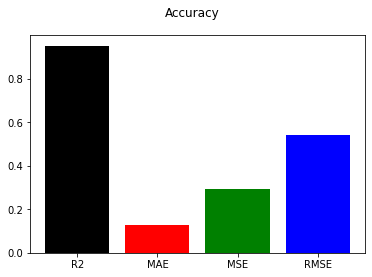

In [ ]:
label = ['R2', 'MAE', 'MSE', 'RMSE']
fig, ax = plt.subplots()
ax.bar(x, y, tick_label=label, color=['black', 'red', 'green', 'blue'])
fig.suptitle('Accuracy')

In [ ]:
min = np.amin(predicted,0)
print(min)
max = np.amax(predicted,0)
max

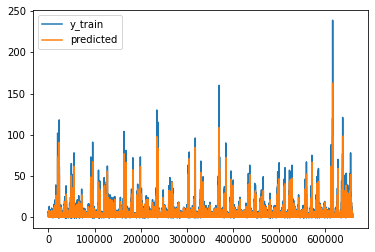

In [ ]:
plt.plot(y_train.values, label='y_train')
plt.plot(predicted, label='predicted')
plt.legend()

In [ ]:
prediction = model.predict(X_test)
prediction

array([1.32798828, 1.05420627, 1.40160826, ..., 1.11987203, 1.08668223,
       1.06819663])

In [ ]:
pred = pd.read_csv('winner.csv', header=None)
prediction = pred[1]


In [ ]:
test = pd.read_csv('test.csv')
test.set_index('index', inplace=True)
test['Predict'] = prediction
print(test)

          商品ID  店舗ID   Predict
index                         
0      1000001     0  1.352254
1      1000001     1  0.947016
2      1000001     2  1.430261
3      1000001     3  6.229402
4      1000001     4  8.026325
...        ...   ...       ...
3055   3500001    13  2.340795
3056   3500001    14  0.184904
3057   3500001    15  0.222026
3058   3500001    16  0.249282
3059   3500001    17  0.382594

[3060 rows x 3 columns]


In [ ]:
answer = pd.read_csv('answer.csv', header=None)
answer = answer.set_index(0)
sum(answer[1])

5129.0

In [ ]:
ans = test.copy()
ans['Predict'] = answer[1]
ans

,商品ID,店舗ID,Predict
index,,,
0,1000001,0,0.0
1,1000001,1,0.0
2,1000001,2,0.0
3,1000001,3,3.0
4,1000001,4,7.0
...,...,...,...
3055,3500001,13,2.0
3056,3500001,14,0.0
3057,3500001,15,0.0


In [ ]:
category_names = pd.read_csv('category_names.csv')

In [ ]:
def get_MSE(array1, array2):
  difference = np.subtract(array1, array2)
  squared = np.square(difference)
  mse = squared.mean()
  return mse

In [ ]:
product_id = test['商品ID'].unique()
product_id

array([1000001, 1000002, 1000003, 1000004, 1000005, 1000006, 1000007,
       1000008, 1000009, 1000010, 1000011, 1002291, 1002377, 1002503,
       1002582, 1100001, 1100002, 1200001, 1200002, 1200003, 1200004,
       1200005, 1200006, 1200007, 1200008, 1200009, 1200010, 1200011,
       1200012, 1200013, 1200014, 1200015, 1200016, 1200017, 1200018,
       1200019, 1200020, 1200021, 1200022, 1200023, 1200024, 1200025,
       1200026, 1200027, 1200028, 1200029, 1200030, 1200031, 1200032,
       1200033, 1200034, 1200035, 1200036, 1200037, 1200038, 1200039,
       1200040, 1201262, 1201269, 1300001, 1300002, 1400001, 1400002,
       1400003, 1400004, 1400898, 1500001, 1600001, 1600002, 1600003,
       1600052, 1600054, 1700001, 1700002, 1700003, 1700004, 1700005,
       1700006, 1700007, 1700008, 1700009, 1700010, 1700011, 1700012,
       1700013, 1700014, 1700015, 1700016, 1700017, 1700018, 1700019,
       1800001, 1800002, 1800003, 1800004, 1800179, 1900001, 1900002,
       2000001, 2000

In [ ]:
list_id = []
list_mse = []
list_rmse = []
for id in product_id:
  array1 = test.query('商品ID == @id')
  array2 = ans.query('商品ID == @id')
  mse = get_MSE(array1.Predict, array2.Predict)
  rmse = np.sqrt(mse)
  list_id.append(id)
  list_mse.append(mse)
  list_rmse.append(rmse)
df = pd.DataFrame(list(zip(list_id, list_mse, list_rmse)), columns = ['商品ID','MSE','RMSE'])
df = pd.merge(df, item_category, on=['商品ID'], how='left')
df = df[['商品ID', '商品カテゴリ名', 'MSE', 'RMSE']]
print(df) 
df.to_excel('/tmp/product_id_mse.xlsx',index=False)

        商品ID            商品カテゴリ名       MSE      RMSE
0    1000001           映画 - DVD  1.756340  1.325270
1    1000002           映画 - DVD  0.538234  0.733644
2    1000003           映画 - DVD  0.459696  0.678009
3    1000004           映画 - DVD  0.599154  0.774050
4    1000005           映画 - DVD  2.816840  1.678344
..       ...                ...       ...       ...
165  3300001          音楽 - レコード  2.018036  1.420576
166  3400001    ゲーム周辺機器 - ゲーム機A  3.495217  1.869550
167  3400002    ゲーム周辺機器 - ゲーム機A  1.268304  1.126190
168  3400003    ゲーム周辺機器 - ゲーム機A  1.606362  1.267423
169  3500001  本 - オーディオブック_タイプB  0.330137  0.574576

[170 rows x 4 columns]


In [ ]:
df

,商品ID,商品カテゴリ名,MSE,RMSE
0,1000001,映画 - DVD,1.756340,1.325270
1,1000002,映画 - DVD,0.538234,0.733644
2,1000003,映画 - DVD,0.459696,0.678009
3,1000004,映画 - DVD,0.599154,0.774050
4,1000005,映画 - DVD,2.816840,1.678344
...,...,...,...,...
165,3300001,音楽 - レコード,2.018036,1.420576
166,3400001,ゲーム周辺機器 - ゲーム機A,3.495217,1.869550
167,3400002,ゲーム周辺機器 - ゲーム機A,1.268304,1.126190
168,3400003,ゲーム周辺機器 - ゲーム機A,1.606362,1.267423


In [ ]:
list_id = []
list_shop_id = []
list_mse = []
list_rmse = []
for id in np.arange(3060):
  mse = get_MSE(test.iloc[id].Predict, ans.iloc[id].Predict)
  rmse = np.sqrt(mse)
  list_id.append(test.iloc[id].商品ID.astype(int))
  list_shop_id.append(test.iloc[id].店舗ID.astype(int))
  list_mse.append(mse)
  list_rmse.append(rmse)
df = pd.DataFrame(list(zip(list_id, list_shop_id, list_mse, list_rmse)), columns = ['商品ID','店舗ID', 'MSE','RMSE'])
df = pd.merge(df, item_category, on=['商品ID'], how='left')
df = df[['商品ID', '店舗ID', 'MSE', 'RMSE']]
print(df) 

         商品ID  店舗ID        MSE      RMSE
0     1000001     0   1.828590  1.352254
1     1000001     1   0.896840  0.947016
2     1000001     2   2.045645  1.430261
3     1000001     3  10.429037  3.229402
4     1000001     4   1.053343  1.026325
...       ...   ...        ...       ...
3055  3500001    13   0.116141  0.340795
3056  3500001    14   0.034189  0.184904
3057  3500001    15   0.049296  0.222026
3058  3500001    16   0.062142  0.249282
3059  3500001    17   0.146378  0.382594

[3060 rows x 4 columns]


In [ ]:
ans1 = ans.copy()
no_price = pd.read_csv('/tmp/no_price.csv')
no_price = pd.merge(no_price, df, on=['商品ID', '店舗ID'], how='left')
no_price.drop(['商品価格', '月ブロック'], axis=1, inplace=True)
no_price.drop(columns=no_price.columns[0], axis=1, inplace=True)
no_price.to_excel('/tmp/no_price_mse.xlsx',index=False)
no_price



In [ ]:
list_index = []
for index, row in df.iterrows():
  if row[2] > 10:
    list_index.append(row[0])
list_index    

[1002582, 1100002, 1600002, 1600003, 2400088, 2800001, 2800090, 2900075]

In [ ]:
ans1 = ans.copy()
test1 = test.copy()

for id in list_index:
  index = ans1.index[ans1['商品ID'] == id].tolist()
  for ind in index:
    ans1.drop(ind, axis=0, inplace=True)
    test1.drop(ind, axis=0, inplace=True)


In [ ]:
list_id = []
list_mse = []
list_rmse = []
for id in np.arange(18):
  array1 = test.query('店舗ID == @id')
  array2 = ans.query('店舗ID == @id')
  mse = get_MSE(array1.Predict, array2.Predict)
  rmse = np.sqrt(mse)
  list_id.append(id)
  list_mse.append(mse)
  list_rmse.append(rmse)
df = pd.DataFrame(list(zip(list_id, list_mse, list_rmse)), columns = ['店舗ID','MSE','RMSE'])  
print(df) 
df.to_excel('/tmp/shop_id_mse.xlsx',index=False)

    店舗ID        MSE      RMSE
0      0  19.076810  4.367701
1      1   4.062550  2.015577
2      2  11.054530  3.324835
3      3  29.262553  5.409487
4      4  12.916975  3.594019
5      5   4.014523  2.003627
6      6   7.401687  2.720604
7      7  32.462501  5.697587
8      8   5.976954  2.444781
9      9  12.388036  3.519664
10    10  21.190882  4.603356
11    11  12.081611  3.475861
12    12   9.871536  3.141900
13    13  22.333656  4.725850
14    14   1.975871  1.405657
15    15   2.655503  1.629571
16    16   3.854080  1.963181
17    17  21.715585  4.659998


In [ ]:
mse = get_MSE(test1.Predict, ans1.Predict)
mse

1.5495391156462621

In [ ]:
r2_score(ans, test)

0.7758286060145432

In [ ]:
r2_RF = r2_score(ans1.Predict, test1.Predict)
mae_RF = mean_absolute_error(ans1.Predict, test1.Predict)
mse_RF = get_MSE(ans1.Predict, test1.Predict)
rmse_RF = np.sqrt(mse_RF)
x = np.arange(4)
y = []
print("R2 : %.3f" % r2_RF)
print("MAE : %.3f" % mae_RF)
print("MSE : %.3f" % mse_RF)
print("RMSE : %.3f" % rmse_RF)
y.append(r2_RF)
y.append(mae_RF)
y.append(mse_RF)
y.append(rmse_RF)

R2 : 0.416
MAE : 0.934
MSE : 1.655
RMSE : 1.286


Text(0.5, 0.98, 'Accuracy')

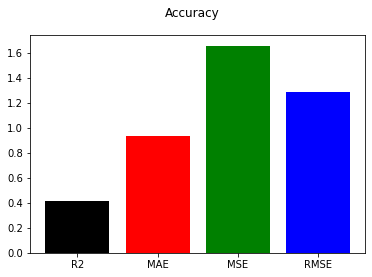

In [ ]:
label = ['R2', 'MAE', 'MSE', 'RMSE']
fig, ax = plt.subplots()
ax.bar(x, y, tick_label=label, color=['black', 'red', 'green', 'blue'])
fig.suptitle('Accuracy')

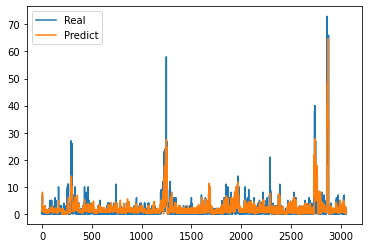

In [ ]:
plt.plot(answer, label='Real')
plt.plot(prediction, label='Predict')
plt.legend()

Text(0, 0.5, 'Real')

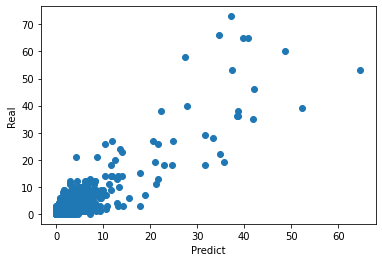

In [ ]:
plt.scatter(prediction, answer)

plt.xlabel("Predict")
plt.ylabel("Real")

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv', header=None)
sample_submission

,0,1
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100
...,...,...
3055,3055,100
3056,3056,100
3057,3057,100
3058,3058,100


In [ ]:
sample_submission[1] = (np.round(prediction_xgb, 0)).astype(int)
sample_submission

,0,1
0,0,2
1,1,2
2,2,2
3,3,2
4,4,6
...,...,...
3055,3055,2
3056,3056,0
3057,3057,1
3058,3058,1


In [ ]:
sum(sample_submission[1])

5909

In [ ]:
sample_submission.to_csv('/tmp/sample_submission.csv', header=False, index=False)

In [ ]:
test = pd.read_csv('test.csv')
test.set_index('index', inplace=True)
test['Predict'] = sample_submission[1]
test.to_excel('/tmp/test.xlsx')